# CapStone Project: Authentication Risk Assessment

**Overview**: In this capstone project, goal is to analyze the login events from 2 month duration to predict normal/anomalous (abnormal) login attempt. Classification of login behaviour will help decide the approprite action - to allow the user to login with regular authentication flow, to require additional/strong authentication or to block/alert the authentication attempt.
We plan to leverage multiple models, namely KMeans, Isolation Forest, Random Forest, and One Class SVM.    



### Getting Started

Our dataset comes from customer login data from Customer Identity and Access Management (IAM) event logs. This data has been anonymized (including synthetic values for select columns) and select column have been removed (with no or low impact on prediction).

We have divided the solution approach into 2 parts:

**Part 1: Exploratory Data Analysis (EDA) and Basic Modeling:**

The primary business objective of this Exploratory Data Analysis (EDA) is to transform raw login event data into a clean, structured, and feature-engineered format suitable for developing machine learning models. These models will be used to predict whether a login attempt is normal or anomalous. The ultimate goal is to enhance authentication risk assessment by providing insights that inform decisions on whether to allow a user to log in with regular authentication, require additional strong authentication, or block/alert the authentication attempt. This involves:

1.  **Understanding Data**: Gaining a deep comprehension of the login event data, its features, and their characteristics.
2.  **Data Cleaning**: Handling missing values, inconsistencies, and irrelevant data to ensure data quality.
3.  **Data Visualization**: Using visual aids to explore distributions, relationships, and potential anomalies within the data.
4.  **Data Transformation**: Encoding categorical variables into numerical formats that are compatible with machine learning algorithms.
5.  **Feature Engineering**: Creating new, meaningful features from existing data to capture patterns relevant to login behavior.

By achieving these objectives, the EDA lays the groundwork for building robust models that can accurately assess authentication risk and support a secure and efficient user experience.

Basic Modeling

K Means and Isolation Forest, Random Forest -> Results

**Part 2 (final):** Tuning + Random Forest and One Class SVM

Note: Tuning Random Forest and One Class SVM are implemented in part 2 (final) of capstone project.



### Understanding the Data

To gain a better understanding of the data, define features in dataset and type of values.
Subsequent to understanding the data, clean the data with missing values/records if necessary.
Input data file has synthetic/anonymized values for select columns (e.g. user identifier, ip addresses).



Use pandas to read in the dataset `authn_event_logs.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
df_login_events = pd.read_csv('data/authn_event_logs.csv')
df_login_events.head()
df_login_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107344 entries, 0 to 107343
Data columns (total 14 columns):
 #   Column                                                   Non-Null Count   Dtype  
---  ------                                                   --------------   -----  
 0   timestamp                                                107344 non-null  float64
 1   outcome.result                                           107344 non-null  object 
 2   actor.id                                                 107344 non-null  int64  
 3   client.ip_address                                        107344 non-null  object 
 4   client.device                                            107344 non-null  object 
 5   client.user_agent.os                                     107344 non-null  object 
 6   client.user_agent.browser                                107344 non-null  object 
 7   client.geographical_context.country                      107342 non-null  object 
 8   client.geograp

List column names and unique value count per column.

In [2]:
for events_col in df_login_events.columns:
    print(f"Column: {events_col}, Unique values: {df_login_events[events_col].nunique()}")

Column: timestamp, Unique values: 107339
Column: outcome.result, Unique values: 3
Column: actor.id, Unique values: 35330
Column: client.ip_address, Unique values: 107342
Column: client.device, Unique values: 4
Column: client.user_agent.os, Unique values: 16
Column: client.user_agent.browser, Unique values: 6
Column: client.geographical_context.country, Unique values: 72
Column: client.geographical_context.city, Unique values: 4128
Column: client.geographical_context.postal_code, Unique values: 7498
Column: target0.alternate_id, Unique values: 3
Column: request.ip_chain.geographical_context.postal_code, Unique values: 8046
Column: request.ip_chain.geographical_context.geolocation.state, Unique values: 292
Column: request.ip_chain.ip, Unique values: 107342


Rename column names with meaningful/short names.


In [3]:
df_login_events.rename(columns={
    'outcome.result': 'outcome_result',
    'actor.id' : 'user_id',
    'client.ip_address': 'client_ip_address',
    'client.device' : 'client_device_type',
    'client.user_agent.os': 'client_os_type',
    'client.user_agent.browser': 'client_browser_type',
    'client.geographical_context.country': 'client_country',
    'client.geographical_context.city': 'client_city',
    'client.geographical_context.postal_code': 'client_postal_code',
    'target0.alternate_id': 'target_application_name',
    'request.ip_chain.geographical_context.postal_code': 'request_ip_postal_code',
    'request.ip_chain.geographical_context.geolocation.state': 'request_ip_state',
    'request.ip_chain.ip': 'request_ip_address'
}, inplace=True)
print("New column names:")
print(df_login_events.columns.tolist())

New column names:
['timestamp', 'outcome_result', 'user_id', 'client_ip_address', 'client_device_type', 'client_os_type', 'client_browser_type', 'client_country', 'client_city', 'client_postal_code', 'target_application_name', 'request_ip_postal_code', 'request_ip_state', 'request_ip_address']



Authentication Login Events Dataset Columns/Features:
```
# Column name
1. timestamp
2. outcome_result: possible values ['CHALLENGE', 'ALLOW', 'DENY']
3. user_id: unique user identifier
4. client_ip_address
5. client_device_type: values ['Computer', 'Mobile', 'Tablet', 'Unknown']
6. client_os_type: ['Windows 10', 'Mac OS X (iPhone)', 'Unknown mobile', 'Mac OS X', 'Android', 'Chrome OS', 'Linux', 'Mac OS X (iPad)', 'Windows 8.1', 'Windows 7', 'Ubuntu', 'Android 5.x Tablet', 'Windows 8', 'Windows 11', 'Mac OS 15.7.2 (Sequoia)', 'Unknown']
7. client_browser_type: values ['CHROMIUM_EDGE', 'CHROME', 'SAFARI', 'UNKNOWN', 'FIREFOX', 'EDGE']
8. client_country
9. client_city
10. client_postal_code
11. target_application_name: values ['AppOne', 'AppThree', 'AppTwo']
12. request_ip_postal_code
13. request_ip_state
14. request_ip_address

```


Analyze unique values for 'outcome_result', 'client_device_type', 'client_os_type', 'client_browser_type', and 'target_application_name' features.

In [4]:
columns_to_analyze = [
    'outcome_result',
    'client_device_type',
    'client_os_type',
    'client_browser_type',
    'target_application_name'
]

for col in columns_to_analyze:
    unique_count = df_login_events[col].nunique()
    print(f"Column: {col}, Unique values: {unique_count}")
    print(df_login_events[col].unique().tolist())
    print("\n")

Column: outcome_result, Unique values: 3
['CHALLENGE', 'ALLOW', 'DENY']


Column: client_device_type, Unique values: 4
['Computer', 'Mobile', 'Tablet', 'Unknown']


Column: client_os_type, Unique values: 16
['Windows 10', 'Mac OS X (iPhone)', 'Unknown mobile', 'Mac OS X', 'Android', 'Chrome OS', 'Linux', 'Mac OS X (iPad)', 'Windows 8.1', 'Windows 7', 'Ubuntu', 'Android 5.x Tablet', 'Windows 8', 'Windows 11', 'Mac OS 15.7.2 (Sequoia)', 'Unknown']


Column: client_browser_type, Unique values: 6
['CHROMIUM_EDGE', 'CHROME', 'SAFARI', 'UNKNOWN', 'FIREFOX', 'EDGE']


Column: target_application_name, Unique values: 3
['AppOne', 'AppThree', 'AppTwo']




Our analysis of normal/abnormal login attempt will be primarily based on time of login, location (state/country) and type of device.
We can delete below features in next step as these are not required for analysis.

1.   outcome_result
2.   client_ip_address
3.   client_os_type
4.   client_browser_type
5.   client_city
6.   client_postal_code
7.   target_application_name
8.   request_ip_postal_code
9.   request_ip_address     


### Clean, Tranform and Visualize the Data

Subsequent to understanding the data, clean the data with missing values/records and explore/visualize the data.

We will delete following features:

outcome_result,
client_ip_address,
client_os_type,
client_browser_type,
client_city,
client_postal_code,
target_application_name,
request_ip_postal_code,
request_ip_address

In [5]:
columns_to_delete = [
    'outcome_result',
    'client_ip_address',
    'client_os_type',
    'client_browser_type',
    'client_city',
    'client_postal_code',
    'target_application_name',
    'request_ip_postal_code',
    'request_ip_address'
]

for col in columns_to_delete:
    if col in df_login_events.columns:
        df_login_events.drop(col, axis=1, inplace=True)
        print(f"Column '{col}' dropped successfully.")
    else:
        print(f"Column '{col}' not found in DataFrame, skipping.")

df_login_events.info()
print("Missing values per column:")
print(df_login_events.isnull().sum())

Column 'outcome_result' dropped successfully.
Column 'client_ip_address' dropped successfully.
Column 'client_os_type' dropped successfully.
Column 'client_browser_type' dropped successfully.
Column 'client_city' dropped successfully.
Column 'client_postal_code' dropped successfully.
Column 'target_application_name' dropped successfully.
Column 'request_ip_postal_code' dropped successfully.
Column 'request_ip_address' dropped successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107344 entries, 0 to 107343
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   timestamp           107344 non-null  float64
 1   user_id             107344 non-null  int64  
 2   client_device_type  107344 non-null  object 
 3   client_country      107342 non-null  object 
 4   request_ip_state    106469 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 4.1+ MB
Missing values per column:
timesta

Print count of unique user ids in login events dataset.

In [ ]:
unique_user_ids = df_login_events['user_id'].nunique()
print(f"Number of unique user_ids: {unique_user_ids}")

Number of unique user_ids: 35329


Analyze missing values and remove the small number of records with missing values for country.

In [6]:
print('Missing values for client_country:')
print(df_login_events['client_country'].isnull().sum())

initial_rows = df_login_events.shape[0]
df_login_events.dropna(subset=['client_country'], inplace=True)
rows_after_deletion = df_login_events.shape[0]

print(f"Initial number of rows: {initial_rows}")
print(f"Number of rows after deleting records with missing client_country: {rows_after_deletion}")
print(f"Number of rows deleted: {initial_rows - rows_after_deletion}")

print('\nMissing values for request_ip_state (to be addressed in subsequent step):')
print(df_login_events['request_ip_state'].isnull().sum())

Missing values for client_country:
2
Initial number of rows: 107344
Number of rows after deleting records with missing client_country: 107342
Number of rows deleted: 2

Missing values for request_ip_state (to be addressed in subsequent step):
873


Handle missing values for request_ip_state. Substitute missing value with 'Unknown_State'. These missing values are present for both United States and other countries.

In [7]:
# Handle missing values in 'request_ip_state'
df_login_events['request_ip_state'] = df_login_events['request_ip_state'].fillna('Unknown_State')
df_login_events['request_ip_state'] = df_login_events['request_ip_state'].replace('', 'Unknown_State')


Add a new feature with time_of_day value (to capture hour value of login attempt).

In [8]:
df_login_events['timestamp_dt'] = pd.to_datetime(df_login_events['timestamp'], unit='s')
df_login_events['time_of_day'] = df_login_events['timestamp_dt'].dt.hour

# Drop the temporary datetime_dt column
df_login_events.drop(columns=['timestamp_dt'], inplace=True)

print("DataFrame head with new 'time_of_day' column:")
display(df_login_events.head())

DataFrame head with new 'time_of_day' column:


,timestamp,user_id,client_device_type,client_country,request_ip_state,time_of_day
0,1.767243e+09,10000,Computer,United States,Michigan,4
1,1.767242e+09,10001,Computer,United States,Maryland,4
2,1.767243e+09,10002,Mobile,United States,Alabama,4
3,1.767242e+09,10003,Computer,United States,District of Columbia,4
4,1.767241e+09,10004,Computer,United States,Kentucky,4


Visualize number of login events per timestamp and hour values.

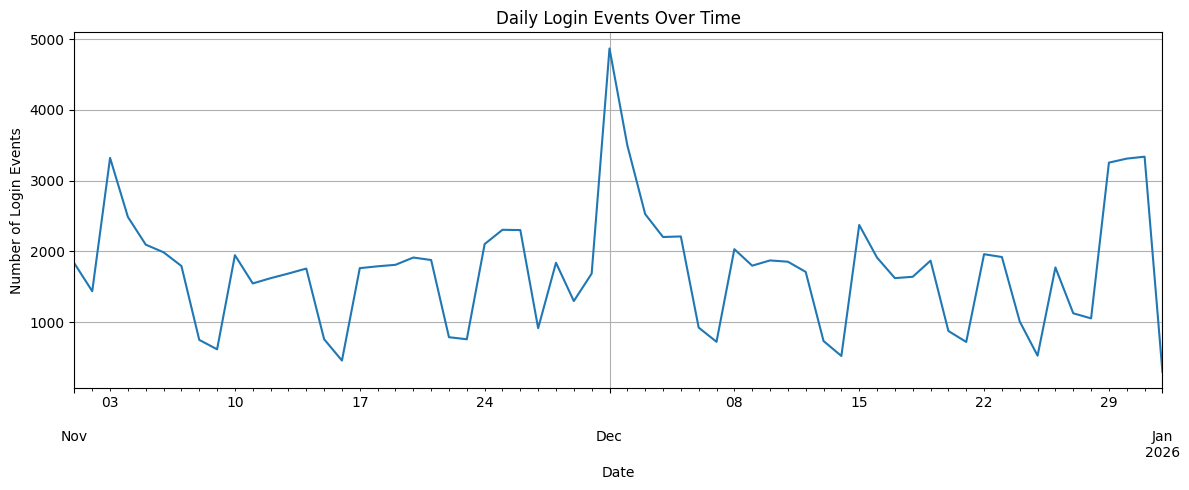

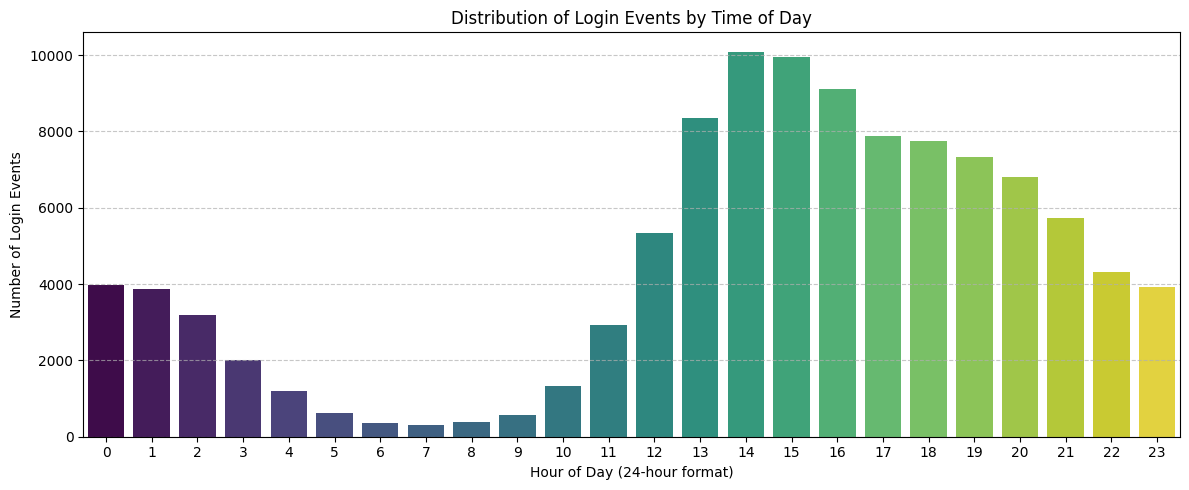

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

df_login_events['timestamp'] = pd.to_datetime(df_login_events['timestamp'], unit='s')

daily_events = df_login_events.set_index('timestamp').resample('D').size()

plt.figure(figsize=(12, 5))
daily_events.plot()
plt.title('Daily Login Events Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Login Events')
plt.grid(True)
plt.tight_layout()
plt.show()


# Calculate the count of login events for each hour of the day
time_of_day_counts = df_login_events['time_of_day'].value_counts().sort_index()

plt.figure(figsize=(12, 5))
sns.barplot(x=time_of_day_counts.index, y=time_of_day_counts.values, palette='viridis', hue=time_of_day_counts.index, legend=False)
plt.title('Distribution of Login Events by Time of Day')
plt.xlabel('Hour of Day (24-hour format)')
plt.ylabel('Number of Login Events')
plt.xticks(range(0, 24)) # Ensure all hours are displayed on x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



Visualize number of login events per country.

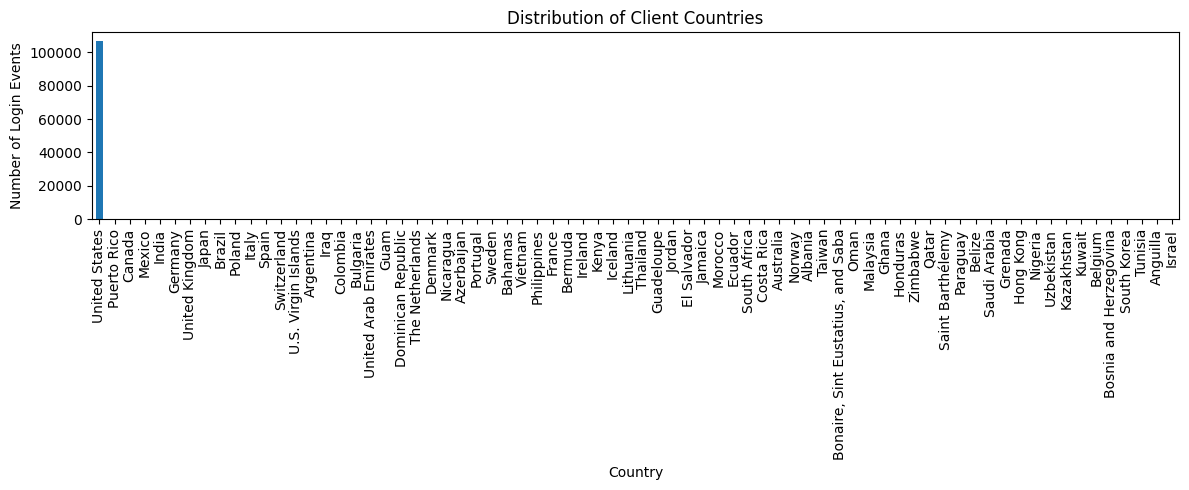

Total number of unique countries: 72
Percentage of login events from United States: 99.36%


In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
df_login_events['client_country'].value_counts().plot(kind='bar')
plt.title('Distribution of Client Countries')
plt.xlabel('Country')
plt.ylabel('Number of Login Events')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

total_events = len(df_login_events)
us_events = df_login_events['client_country'].value_counts().get('United States', 0)
us_percentage = (us_events / total_events) * 100
print(f"Total number of unique countries: {df_login_events['client_country'].nunique()}")
print(f"Percentage of login events from United States: {us_percentage:.2f}%")

Create a new feature with name country_category to define whether country is United States or other country (International).

In [11]:
import numpy as np

# Recreate country_category column
df_login_events['country_category'] = np.where(df_login_events['client_country'] == 'United States', 'United States', 'International')

non_us_states_in_request_ip = df_login_events[df_login_events['country_category'] == 'International']['request_ip_state'].unique().tolist()
print("Unique 'request_ip_state' values for non-US countries:")
print(non_us_states_in_request_ip)
print(f"Number of unique 'request_ip_state' values for non-US countries: {len(non_us_states_in_request_ip)}")

Unique 'request_ip_state' values for non-US countries:
['Dubai', 'Saint Thomas Island', 'Unknown_State', 'Saint Croix Island', 'Warwick Parish', 'Tirana', 'Yamagata', 'Tokyo', 'Ontario', 'Rio de Janeiro', 'Quebec', 'Greater Accra Region', 'Corrientes', 'Mendoza', 'Vaud', 'Metro Manila', 'Mazovia', 'Hesse', 'Catalonia', 'Espaillat Province', 'England', 'Baden-Wurttemberg', 'Haryana', 'Limburg', 'Puerto Plata', 'Andalusia', 'Okinawa', 'Mexico City', 'Amman Governorate', 'Kuala Lumpur', 'Khon Kaen', 'Newfoundland and Labrador', 'Tamil Nadu', 'Baghdad', 'Muscat', 'San Salvador Department', 'Antioquia', 'Capital Region', 'Nairobi County', 'British Columbia', 'Bavaria', 'Paraná', 'Alberta', 'New Providence District', 'Vilnius', 'Aargau', 'Managua Department', 'São Paulo', 'Friuli Venezia Giulia', 'Stockholm County', 'New Brunswick', 'Zurich', 'Telangana', 'Bonaire', 'Madhya Pradesh', 'Ceará', 'Taipei City', 'Oslo County', 'Santa Catarina', 'Pennsylvania,Ontario', 'Gauteng', 'Bogota D.C.', 'M

Visualize number of login events per country_category.

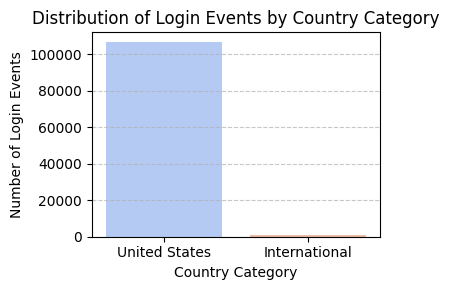

Login events by country category:
country_category
United States    106651
International       691
Name: count, dtype: int64


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the value counts for the country_category
country_category_counts = df_login_events['country_category'].value_counts()

plt.figure(figsize=(4, 3))
sns.barplot(x=country_category_counts.index, y=country_category_counts.values, palette='coolwarm', hue=country_category_counts.index, legend=False)
plt.title('Distribution of Login Events by Country Category')
plt.xlabel('Country Category')
plt.ylabel('Number of Login Events')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Login events by country category:")
print(country_category_counts)

Analyze and clean the state value. Select records have comma seperated values with two state names for state field.

In [13]:
comma_separated_states_count = df_login_events['request_ip_state'].astype(str).str.contains(',').sum()
print(f"Number of records in 'request_ip_state' with comma-separated values: {comma_separated_states_count}")
import numpy as np

def clean_state_entry(state):
    if pd.isna(state):
        return state  # Return NaN as is
    if isinstance(state, str) and ',' in state:
        return state.split(',')[0]
    return state

print(f"Unique states before cleaning: {df_login_events['request_ip_state'].nunique()}")

df_login_events['request_ip_state'] = df_login_events['request_ip_state'].apply(clean_state_entry)

print(f"Unique states after cleaning: {df_login_events['request_ip_state'].nunique()}")

print("Unique state names for US logins after cleaning:")
# Filter for US events again to reflect the cleaning
us_login_events_cleaned = df_login_events[df_login_events['client_country'] == 'United States']
print(us_login_events_cleaned['request_ip_state'].unique().tolist())

Number of records in 'request_ip_state' with comma-separated values: 1036
Unique states before cleaning: 293
Unique states after cleaning: 179
Unique state names for US logins after cleaning:
['Michigan', 'Maryland', 'Alabama', 'District of Columbia', 'Kentucky', 'South Carolina', 'Georgia', 'Unknown_State', 'North Carolina', 'Virginia', 'Illinois', 'Florida', 'Missouri', 'Mississippi', 'Texas', 'Tennessee', 'Pennsylvania', 'Delaware', 'New Jersey', 'West Virginia', 'Ohio', 'Washington', 'Hawaii', 'California', 'Vermont', 'Massachusetts', 'Colorado', 'Louisiana', 'Maine', 'Arizona', 'New York', 'Utah', 'South Dakota', 'Connecticut', 'Indiana', 'Oklahoma', 'Wisconsin', 'Alaska', 'Arkansas', 'Iowa', 'Nebraska', 'Nevada', 'New Hampshire', '', 'Oregon', 'Kansas', 'Rhode Island', 'Idaho', 'Wyoming', 'Minnesota', 'North Dakota', 'Tunapuna/Piarco', 'New Mexico', 'Montana', 'Provincia de Panamá', 'Pichincha']


Visual login events for top 20 states.

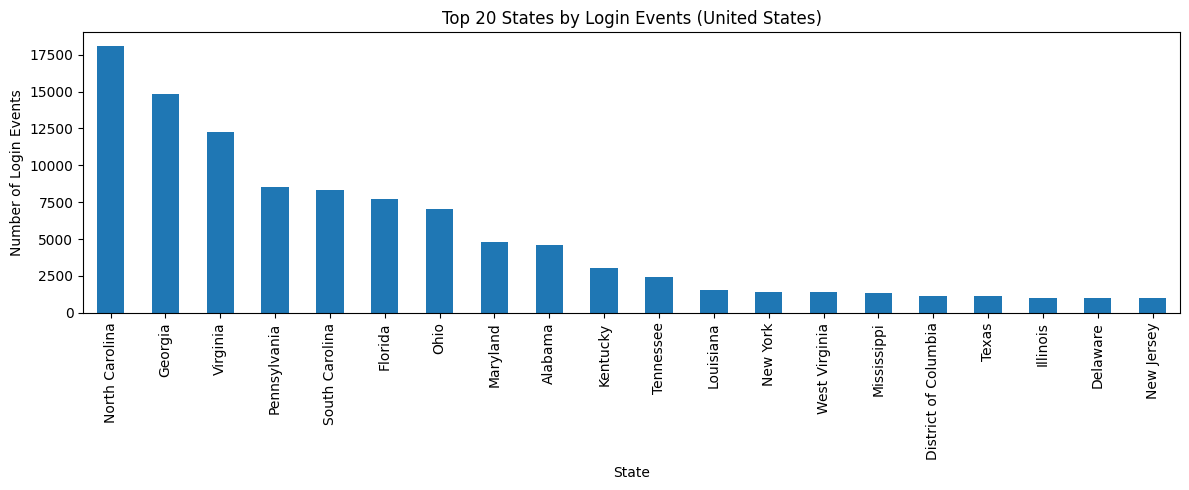

In [14]:
import matplotlib.pyplot as plt

top_20_states_cleaned = us_login_events_cleaned['request_ip_state'].value_counts().head(20)

plt.figure(figsize=(12, 5))
top_20_states_cleaned.plot(kind='bar')
plt.title('Top 20 States by Login Events (United States)')
plt.xlabel('State')
plt.ylabel('Number of Login Events')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Create the new state_category feature with the five specified values: 'Top 20 US State', 'Remaining US State', 'Unknown US State', 'International State', and 'Unknown International State'. This will provide a more detailed and accurate categorization of login event locations.

In [15]:
import numpy as np

top_20_state_names = top_20_states_cleaned.index.tolist()

conditions = [
    (df_login_events['client_country'] == 'United States') & (df_login_events['request_ip_state'].isin(top_20_state_names)),
    (df_login_events['client_country'] == 'United States') & (df_login_events['request_ip_state'] == 'Unknown_State'),
    (df_login_events['client_country'] == 'United States') & (~df_login_events['request_ip_state'].isin(top_20_state_names)) & (df_login_events['request_ip_state'] != 'Unknown_State'),
    (df_login_events['client_country'] != 'United States') & (df_login_events['request_ip_state'] != 'Unknown_State'),
    (df_login_events['client_country'] != 'United States') & (df_login_events['request_ip_state'] == 'Unknown_State')
]

choices = [
    'Top 20 US State',
    'Unknown US State',
    'Remaining US State',
    'International State',
    'Unknown International State'
]

df_login_events['state_category'] = np.select(conditions, choices, default='Other') # 'Other' for any unforeseen edge cases

print("Value counts for the new 'state_category' column:")
print(df_login_events['state_category'].value_counts())

df_login_events.head()

Value counts for the new 'state_category' column:
state_category
Top 20 US State                102816
Remaining US State               3269
Unknown US State                  566
International State               384
Unknown International State       307
Name: count, dtype: int64


,timestamp,user_id,client_device_type,client_country,request_ip_state,time_of_day,country_category,state_category
0,2026-01-01 04:52:18.309999943,10000,Computer,United States,Michigan,4,United States,Remaining US State
1,2026-01-01 04:40:38.510999918,10001,Computer,United States,Maryland,4,United States,Top 20 US State
2,2026-01-01 04:57:53.970000029,10002,Mobile,United States,Alabama,4,United States,Top 20 US State
3,2026-01-01 04:28:47.693000078,10003,Computer,United States,District of Columbia,4,United States,Top 20 US State
4,2026-01-01 04:23:37.773999929,10004,Computer,United States,Kentucky,4,United States,Top 20 US State


Visual login events for state_category values:

* Top 20 US State                102816
* Remaining US State               3217
* Unknown US State                  618
* International State               384
* Unknown International State       309


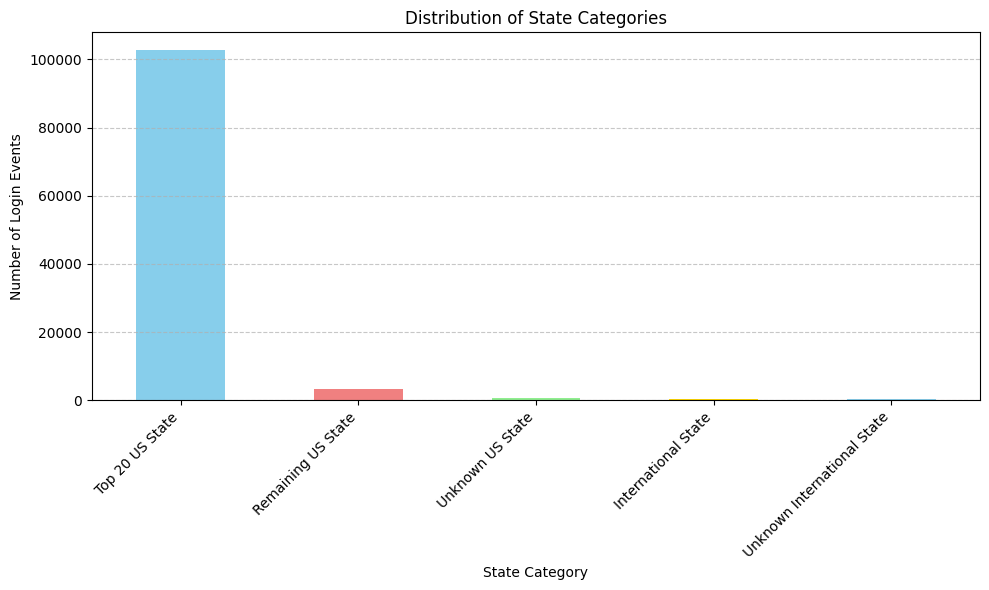

In [16]:
import matplotlib.pyplot as plt

# Calculate the value counts for the state_category
state_category_counts = df_login_events['state_category'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
state_category_counts.plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.title('Distribution of State Categories')
plt.xlabel('State Category')
plt.ylabel('Number of Login Events')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Analyze client_device_type values and distribution across login events dataset.

In [17]:
print("Unique values and counts for client_device_type:")
print(df_login_events['client_device_type'].value_counts())
initial_rows = df_login_events.shape[0]
df_login_events = df_login_events[~df_login_events['client_device_type'].isin(['Unknown'])].copy()
rows_after_deletion = df_login_events.shape[0]

print(f"Initial number of rows: {initial_rows}")
print(f"Number of rows after deleting 'Unknown' device types: {rows_after_deletion}")
print(f"Number of rows deleted: {initial_rows - rows_after_deletion}")

Unique values and counts for client_device_type:
client_device_type
Computer    66690
Mobile      40354
Tablet        296
Unknown         2
Name: count, dtype: int64
Initial number of rows: 107342
Number of rows after deleting 'Unknown' device types: 107340
Number of rows deleted: 2


In [21]:
df_login_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107340 entries, 0 to 107343
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   timestamp           107340 non-null  datetime64[ns]
 1   user_id             107340 non-null  int64         
 2   client_device_type  107340 non-null  object        
 3   client_country      107340 non-null  object        
 4   request_ip_state    107340 non-null  object        
 5   time_of_day         107340 non-null  int32         
 6   country_category    107340 non-null  object        
 7   state_category      107340 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(1), object(5)
memory usage: 7.0+ MB


### Feature Engineering

In this step, we will create new feature to better represent select fields numerically (including encoding the values).  This step will prepare the features and target column for modeling with appropriate encoding and transformations.

Create a new column device_category to capture numeric encoding corrosponding to client_device_type values. We will encode both tablet and mobile to 0 value as both are similar category for this analysis (in addition to fact that tablet value records are low).

In [27]:
import pandas as pd

# Define a comprehensive mapping for all expected string values to their final integer representation
device_mapping = {
    'Computer': 1,
    'Mobile': 0,
    'Tablet': 0
}

# Check if 'device_category' is already numerical to skip re-encoding
if not pd.api.types.is_integer_dtype(df_login_events['device_category']):
    print(f"Unique values in 'client_device_type' before mapping for 'device_category': {df_login_events['client_device_type'].astype(str).unique().tolist()}")
    # Apply the mapping to create the new 'device_category' column.
    df_login_events['device_category'] = df_login_events['client_device_type'].astype(str).map(device_mapping).fillna(0).astype(int)
    print("Device category encoded to numerical values.")
else:
    print("'device_category' is already numerically encoded.")

print(f"\nNew 'device_category' value counts:")
print(df_login_events['device_category'].value_counts())


print("\nDataFrame head with new 'device_category' column:")
display(df_login_events.head())

'device_category' is already numerically encoded.

New 'device_category' value counts:
device_category
1    66690
0    40650
Name: count, dtype: int64

DataFrame head with new 'device_category' column:


,timestamp,user_id,client_device_type,client_country,request_ip_state,time_of_day,country_category,state_category,device_category
0,2026-01-01 04:52:18.309999943,10000,Computer,United States,Michigan,4,1,Remaining US State,1
1,2026-01-01 04:40:38.510999918,10001,Computer,United States,Maryland,4,1,Top 20 US State,1
2,2026-01-01 04:57:53.970000029,10002,Mobile,United States,Alabama,4,1,Top 20 US State,0
3,2026-01-01 04:28:47.693000078,10003,Computer,United States,District of Columbia,4,1,Top 20 US State,1
4,2026-01-01 04:23:37.773999929,10004,Computer,United States,Kentucky,4,1,Top 20 US State,1


### Explanation of 'device_category' Feature Engineering:

The `device_category` feature was engineered to simplify the `client_device_type` information into a binary, numerical representation suitable for machine learning models. This involved a few key steps:

1.  **Consolidation of Device Types**:
    Initially, `client_device_type` had categories like 'Computer', 'Mobile', 'Tablet', and 'Unknown'. To streamline the feature, 'Tablet' was consolidated into the 'Mobile' category, as both represent portable, non-desktop devices. The 'Unknown' device types were also removed from the dataset during an earlier cleaning step.

2.  **Numerical Encoding**:
    After consolidating device types, the feature was numerically encoded into a binary format:

    *   'Mobile' and 'Tablet' are mapped to **0**.
    *   'Computer' was mapped to **1**.

    This transformation converts a categorical feature into a numerical one, where `0` generally represents mobile/tablet devices and `1` represents traditional computer devices. This binary encoding allows machine learning algorithms to easily process and leverage this information for anomaly detection or classification tasks.

In [25]:
import numpy as np

# Check if 'country_category' is already numerical (int64) to skip re-encoding
if not pd.api.types.is_integer_dtype(df_login_events['country_category']):
    country_mapping = {'United States': 1, 'International': 0}
    df_login_events['country_category'] = df_login_events['country_category'].map(country_mapping).astype(int)
    print("Country category encoded to numerical values.")
else:
    print("'country_category' is already numerically encoded.")

print("Unique values and counts for 'country_category' after encoding:")
print(df_login_events['country_category'].value_counts())
print(f"\nData type of 'country_category' column: {df_login_events['country_category'].dtype}")

'country_category' is already numerically encoded.
Unique values and counts for 'country_category' after encoding:
country_category
1    106649
0       691
Name: count, dtype: int64

Data type of 'country_category' column: int64


### Explanation of 'country_category' Feature Engineering:

The `country_category` feature was created to provide a simplified, aggregated view of the geographical location of login events, categorizing them primarily by whether they originated from the United States or an international location. This process involved two main steps:

1.  **Initial Categorization into String Categories**:
    A new column named `country_category` was added to the `df_login_events` DataFrame. This column was populated based on a conditional logic:

    *   If the `client_country` was 'United States', the `country_category` was assigned the string value 'United States'.
    *   For any other `client_country`, the `country_category` was assigned the string value 'International'.

    This step effectively groups all non-US countries into a single 'International' category, which can be useful for models that need to distinguish between domestic and international access patterns without needing fine-grained country-level detail.

2.  **Numerical Encoding**:
    Following the creation of the string-based categories, the `country_category` column was converted into a numerical representation suitable for machine learning models. A simple mapping was applied:

    *   'United States' was mapped to **1**.
    *   'International' was mapped to **0**.

    This numerical encoding provides a binary representation for the geographical origin, allowing machine learning algorithms to process this feature efficiently.

Encode state_category numerically: Replace the string values in the state_category column with their specified numerical mappings: 'Top 20 US State' to 5, 'Remaining US State' to 4, 'Unknown US State' to 3, 'International State' to 2, and 'Unknown International State' to 1. Convert the column to an integer data type.

In [29]:
import numpy as np
import pandas as pd

top_20_state_names = ['North Carolina', 'Georgia', 'Virginia', 'Pennsylvania', 'South Carolina', 'Florida', 'Ohio', 'Maryland', 'Alabama', 'Kentucky', 'Tennessee', 'Louisiana', 'New York', 'West Virginia', 'Mississippi', 'District of Columbia', 'Texas', 'Delaware', 'Illinois', 'New Jersey']

# Check if 'state_category' is already numerically encoded
if not pd.api.types.is_integer_dtype(df_login_events['state_category']):
    conditions = [
        (df_login_events['client_country'] == 'United States') & (df_login_events['request_ip_state'].isin(top_20_state_names)),
        (df_login_events['client_country'] == 'United States') & (df_login_events['request_ip_state'] == 'Unknown_State'),
        (df_login_events['client_country'] == 'United States') & (~df_login_events['request_ip_state'].isin(top_20_state_names)) & (df_login_events['request_ip_state'] != 'Unknown_State'),
        (df_login_events['client_country'] != 'United States') & (df_login_events['request_ip_state'] != 'Unknown_State'),
        (df_login_events['client_country'] != 'United States') & (df_login_events['request_ip_state'] == 'Unknown_State')
    ]

    choices = [
        'Top 20 US State',
        'Unknown US State',
        'Remaining US State',
        'International State',
        'Unknown International State'
    ]

    df_login_events['state_category'] = np.select(conditions, choices, default='Other')

    # Now, apply the numerical mapping as requested
    state_category_mapping = {
        'Top 20 US State': 5,
        'Remaining US State': 4,
        'Unknown US State': 3,
        'International State': 2,
        'Unknown International State': 1
    }

    df_login_events['state_category'] = df_login_events['state_category'].map(state_category_mapping).fillna(0).astype(int)
    print("State category encoded to numerical values.")
else:
    print("'state_category' is already numerically encoded.")

print("Unique values and counts for 'state_category' after encoding:")
print(df_login_events['state_category'].value_counts())
print(f"\nData type of 'state_category' column: {df_login_events['state_category'].dtype}")

'state_category' is already numerically encoded.
Unique values and counts for 'state_category' after encoding:
state_category
5    102815
4      3268
3       566
2       384
1       307
Name: count, dtype: int64

Data type of 'state_category' column: int64


### Explanation of 'state_category' Feature Engineering:

The `state_category` feature was created to categorize login events based on their geographical state, providing a more structured representation for analysis and modeling. This involved two main steps: initial categorization based on country and state, and then numerical encoding.

1.  **Initial Categorization into String Categories**:
    A new column named `state_category` was created by applying a series of conditions using `numpy.select`. This categorized each login event into one of five distinct categories:

    *   **'Top 20 US State'**: Assigned if the `client_country` was 'United States' and the `request_ip_state` was one of the identified top 20 states with the most login events.
    *   **'Remaining US State'**: Assigned if the `client_country` was 'United States' and the `request_ip_state` was not in the top 20, nor was it 'Unknown_State'.
    *   **'Unknown US State'**: Assigned if the `client_country` was 'United States' and the `request_ip_state` was 'Unknown_State'.
    *   **'International State'**: Assigned if the `client_country` was not 'United States' and the `request_ip_state` was not 'Unknown_State'.
    *   **'Unknown International State'**: Assigned if the `client_country` was not 'United States' and the `request_ip_state` was 'Unknown_State'.

    This categorization helps differentiate between highly frequent US states, less frequent US states, and international locations, while also accounting for missing state information.

2.  **Numerical Encoding**:
    Following the initial string categorization, these categories were converted into numerical representations to make them suitable for machine learning models. A specific mapping was applied:

    *   'Top 20 US State' was mapped to **5**
    *   'Remaining US State' was mapped to **4**
    *   'Unknown US State' was mapped to **3**
    *   'International State' was mapped to **2**
    *   'Unknown International State' was mapped to **1**

    This numerical encoding provides an ordinal scale, where higher numbers generally represent more specific or 'known' geographical contexts within the US, potentially reflecting a hierarchy or importance in the context of login event analysis.

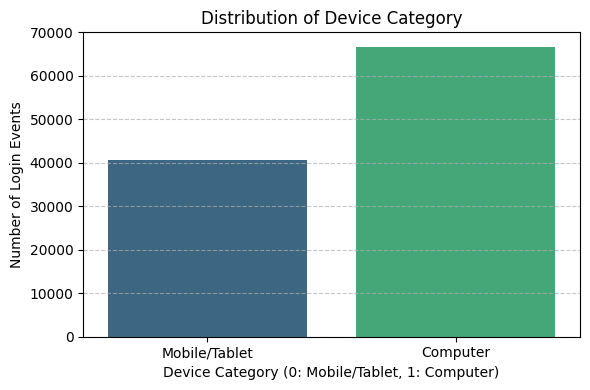

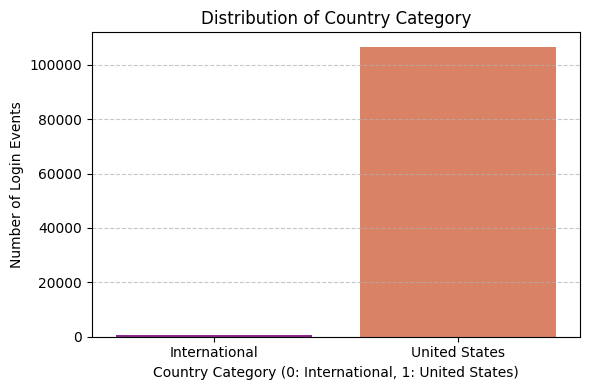

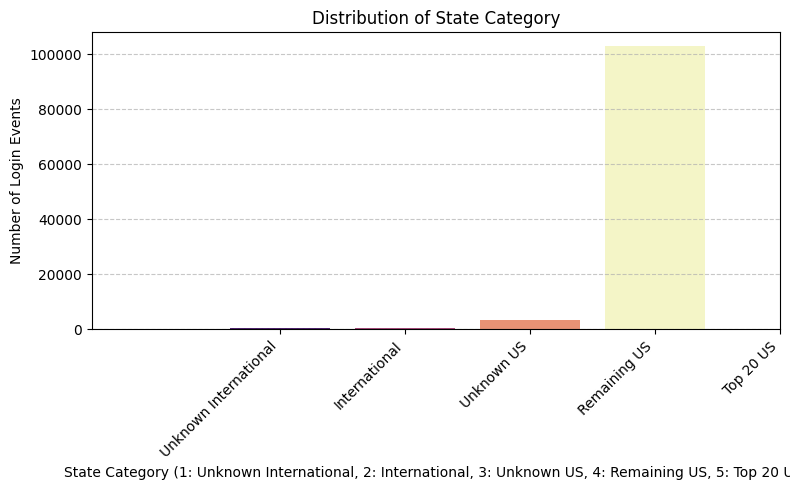

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize device_category distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='device_category', data=df_login_events, palette='viridis', hue='device_category', legend=False)
plt.title('Distribution of Device Category')
plt.xlabel('Device Category (0: Mobile/Tablet, 1: Computer)')
plt.ylabel('Number of Login Events')
plt.xticks(ticks=[0, 1], labels=['Mobile/Tablet', 'Computer'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Visualize country_category distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='country_category', data=df_login_events, palette='plasma', hue='country_category', legend=False)
plt.title('Distribution of Country Category')
plt.xlabel('Country Category (0: International, 1: United States)')
plt.ylabel('Number of Login Events')
plt.xticks(ticks=[0, 1], labels=['International', 'United States'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Visualize state_category distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='state_category', data=df_login_events, palette='magma', hue='state_category', legend=False)
plt.title('Distribution of State Category')
plt.xlabel('State Category (1: Unknown International, 2: International, 3: Unknown US, 4: Remaining US, 5: Top 20 US)')
plt.ylabel('Number of Login Events')
plt.xticks(ticks=[1, 2, 3, 4, 5], labels=['Unknown International', 'International', 'Unknown US', 'Remaining US', 'Top 20 US'], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [32]:
print("Summary statistics for df_login_events:")
display(df_login_events.info())

Summary statistics for df_login_events:
<class 'pandas.core.frame.DataFrame'>
Index: 107340 entries, 0 to 107343
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   timestamp           107340 non-null  datetime64[ns]
 1   user_id             107340 non-null  int64         
 2   client_device_type  107340 non-null  object        
 3   client_country      107340 non-null  object        
 4   request_ip_state    107340 non-null  object        
 5   time_of_day         107340 non-null  int32         
 6   country_category    107340 non-null  int64         
 7   state_category      107340 non-null  int64         
 8   device_category     107340 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(4), object(3)
memory usage: 7.8+ MB


None

We are creating a new file as result of EDA (including feature engineering). This updated data file will be used as starting point (input) in final part of capstone project.

In [33]:
df_login_events.to_csv('data/login_events_final.csv', index=False)
print("df_login_events saved to data/login_events_final.csv")

df_login_events saved to data/login_events_final.csv


Create a new dataframe with select features ['time_of_day', 'country_category', 'state_category', 'device_category'] for running K Means and Isolation Forest models.

In [35]:
df_login_events_final = df_login_events[['time_of_day', 'country_category', 'state_category', 'device_category']].copy()

print("First 5 rows of df_login_events_final:")
display(df_login_events_final.head())

print("\nInfo of df_login_events_final:")
df_login_events_final.info()

First 5 rows of df_login_events_final:


,time_of_day,country_category,state_category,device_category
0,4,1,4,1
1,4,1,5,1
2,4,1,5,0
3,4,1,5,1
4,4,1,5,1



Info of df_login_events_final:
<class 'pandas.core.frame.DataFrame'>
Index: 107340 entries, 0 to 107343
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   time_of_day       107340 non-null  int32
 1   country_category  107340 non-null  int64
 2   state_category    107340 non-null  int64
 3   device_category   107340 non-null  int64
dtypes: int32(1), int64(3)
memory usage: 3.7 MB


# KMeans Model

As noted in data analysis, we don't have login events labeled with risk assessment outcome. We need to analyze the outliers from login events dataset and create a new feature which will be used for supervised learning algorith in final part of capstone project.
We are using KMeans as a base model for clustering of login events into normal and outlier group based on time_of_day, country_category, state_category and device_category features. In next steps, we will use Isolation Forest and compare what to pick for defining target risk assessemet label feature.

In [36]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Ensure df_login_events_final contains all the features for scaling
df_login_events_final = df_login_events[['time_of_day', 'country_category', 'state_category', 'device_category']].copy()

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the data
X_scaled = scaler.fit_transform(df_login_events_final)

# Convert scaled array back to DataFrame for easier inspection if needed, though KMeans can take the array
X_scaled_df = pd.DataFrame(X_scaled, columns=df_login_events_final.columns, index=df_login_events_final.index)

# Initialize KMeans with 2 clusters and a random state for reproducibility
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')

# Fit KMeans to the scaled data and get cluster labels
df_login_events_final['kmeans_cluster'] = kmeans.fit_predict(X_scaled_df)

print("First 5 rows of df_login_events_final with kmeans_cluster after scaling:")
display(df_login_events_final.head())

print("\nK-Means Cluster distribution:")
print(df_login_events_final['kmeans_cluster'].value_counts())

First 5 rows of df_login_events_final with kmeans_cluster after scaling:


,time_of_day,country_category,state_category,device_category,kmeans_cluster
0,4,1,4,1,0
1,4,1,5,1,0
2,4,1,5,0,1
3,4,1,5,1,0
4,4,1,5,1,0



K-Means Cluster distribution:
kmeans_cluster
0    66690
1    40650
Name: count, dtype: int64


In [37]:
print("\n--- Analysis of Cluster 0 ---")
cluster_0_data = df_login_events_final[df_login_events_final['kmeans_cluster'] == 0]
print("Mean time_of_day for Cluster 0:", cluster_0_data['time_of_day'].mean())
print("Country category distribution for Cluster 0:\n", cluster_0_data['country_category'].value_counts(normalize=True))
print("State category distribution for Cluster 0:\n", cluster_0_data['state_category'].value_counts(normalize=True))
print("Device category distribution for Cluster 0:\n", cluster_0_data['device_category'].value_counts(normalize=True))

print("\n--- Analysis of Cluster 1 ---")
cluster_1_data = df_login_events_final[df_login_events_final['kmeans_cluster'] == 1]
print("Mean time_of_day for Cluster 1:", cluster_1_data['time_of_day'].mean())
print("Country category distribution for Cluster 1:\n", cluster_1_data['country_category'].value_counts(normalize=True))
print("State category distribution for Cluster 1:\n", cluster_1_data['state_category'].value_counts(normalize=True))
print("Device category distribution for Cluster 1:\n", cluster_1_data['device_category'].value_counts(normalize=True))


--- Analysis of Cluster 0 ---
Mean time_of_day for Cluster 0: 14.85982905982906
Country category distribution for Cluster 0:
 country_category
1    0.993372
0    0.006628
Name: proportion, dtype: float64
State category distribution for Cluster 0:
 state_category
5    0.957295
4    0.029180
3    0.006898
2    0.003764
1    0.002864
Name: proportion, dtype: float64
Device category distribution for Cluster 0:
 device_category
1    1.0
Name: proportion, dtype: float64

--- Analysis of Cluster 1 ---
Mean time_of_day for Cluster 1: 13.644083640836408
Country category distribution for Cluster 1:
 country_category
1    0.993875
0    0.006125
Name: proportion, dtype: float64
State category distribution for Cluster 1:
 state_category
5    0.958745
4    0.032522
2    0.003272
1    0.002854
3    0.002608
Name: proportion, dtype: float64
Device category distribution for Cluster 1:
 device_category
0    1.0
Name: proportion, dtype: float64


### Explanation of Characteristics Differentiating Cluster 0 and Cluster 1

Based on the analysis of the feature distributions within each cluster, here are the key characteristics that differentiate Cluster 0 and Cluster 1:

**Cluster 0 (Larger Cluster: 66,690 events)**
*   **Device Category**: Exclusively `Computer` (100%).
*   **Time of Day**: Mean `time_of_day` is approximately **14.86 (2:52 PM)**, indicating logins during typical daytime hours.
*   **Country Category**: Overwhelmingly from the **United States** (99.34%).
*   **State Category**: Primarily from **Top 20 US States** (95.73%), with a smaller proportion from 'Remaining US State' and 'Unknown US State'.

**Cluster 1 (Smaller Cluster: 40,650 events)**
*   **Device Category**: Exclusively `Mobile/Tablet` (100%).
*   **Time of Day**: Mean `time_of_day` is approximately **13.64 (1:38 PM)**, slightly earlier than Cluster 0.
*   **Country Category**: Also predominantly from the **United States** (99.39%), very similar to Cluster 0.
*   **State Category**: Primarily from **Top 20 US States** (95.87%), with a slightly larger proportion from 'Remaining US State' compared to Cluster 0.

**Key Differentiator**: The most significant factor distinguishing these two clusters is the **`device_category`**. Cluster 0 is almost entirely composed of computer logins, while Cluster 1 is entirely mobile/tablet logins. `time_of_day` also shows a slight difference, but `country_category` and `state_category` distributions are very similar across both clusters, suggesting these geographical features are not primary differentiators for these specific K-Means clusters.

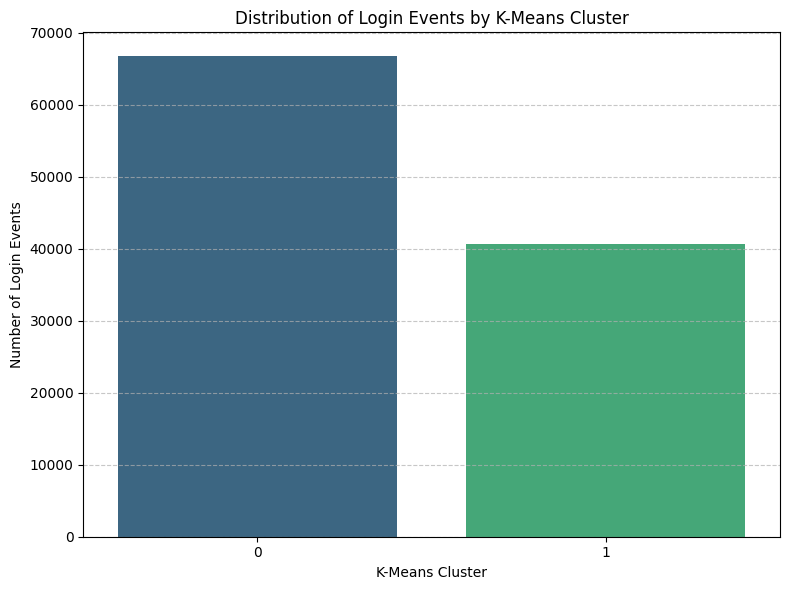

Login events by K-Means Cluster:
kmeans_cluster
0    66690
1    40650
Name: count, dtype: int64


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the value counts for the kmeans_cluster
kmeans_cluster_counts = df_login_events_final['kmeans_cluster'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
sns.barplot(x=kmeans_cluster_counts.index, y=kmeans_cluster_counts.values, palette='viridis', hue=kmeans_cluster_counts.index, legend=False)
plt.title('Distribution of Login Events by K-Means Cluster')
plt.xlabel('K-Means Cluster')
plt.ylabel('Number of Login Events')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Login events by K-Means Cluster:")
print(kmeans_cluster_counts)

KMeans clustering into 2 clusters has not provided any meaningful result to define outliers (with standard scaling) which are expected to be smaller percentage (not more than 5%).

# Isolation Forest Model

Use Isolation Forest to build a model to indetify outliers. In this model we are setting contamination parameter to 0.05 (which shall result in approximately 5% outliers).

In [39]:
from sklearn.ensemble import IsolationForest
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Ensure df_login_events_final contains all the features
# We will use time_of_day, country_category, state_category and device_category

X_features = df_login_events_final[['time_of_day', 'country_category', 'state_category', 'device_category']]

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the data
X_scaled_iso = scaler.fit_transform(X_features)

# Convert scaled array back to DataFrame for easier inspection if needed
X_scaled_iso_df = pd.DataFrame(X_scaled_iso, columns=X_features.columns, index=X_features.index)

# Initialize the Isolation Forest model
# n_estimators: number of base estimators (trees) in the ensemble
# contamination: the proportion of outliers in the data set (important for thresholding)
# random_state: for reproducibility
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42, n_jobs=-1)

# Fit the model to the scaled data
iso_forest.fit(X_scaled_iso_df)

# Predict anomaly scores (lower score indicates higher anomaly)
anomaly_scores = iso_forest.decision_function(X_scaled_iso_df)

# Predict whether a sample is an outlier or not (-1 for outliers and 1 for inliers)
anomaly_predictions = iso_forest.predict(X_scaled_iso_df)

# Add the anomaly scores and predictions to a copy of the features DataFrame for display
X_with_anomalies = X_features.copy()
X_with_anomalies['anomaly_score'] = anomaly_scores
X_with_anomalies['anomaly_prediction'] = anomaly_predictions

print("First 5 rows of data with Isolation Forest anomaly scores and predictions:")
display(X_with_anomalies.head())

print("\nAnomaly prediction distribution:")
print(X_with_anomalies['anomaly_prediction'].value_counts())

print("\nInterpretation of Anomaly Prediction:")
print("-  1: Inlier (normal data point)")
print("- -1: Outlier (anomalous data point)")

First 5 rows of data with Isolation Forest anomaly scores and predictions:


,time_of_day,country_category,state_category,device_category,anomaly_score,anomaly_prediction
0,4,1,4,1,-0.115656,-1
1,4,1,5,1,0.003623,1
2,4,1,5,0,0.012224,1
3,4,1,5,1,0.003623,1
4,4,1,5,1,0.003623,1



Anomaly prediction distribution:
anomaly_prediction
 1    102452
-1      4888
Name: count, dtype: int64

Interpretation of Anomaly Prediction:
-  1: Inlier (normal data point)
- -1: Outlier (anomalous data point)


In [50]:
import pandas as pd

outliers_data = X_with_anomalies[X_with_anomalies['anomaly_prediction'] == -1].copy()
inliers_data = X_with_anomalies[X_with_anomalies['anomaly_prediction'] == 1].copy()

print("--- Comparison of Outliers vs. Inliers ---")
print(f"Total Outliers: {len(outliers_data)}")
print(f"Total Inliers: {len(inliers_data)}")

print("\n--- Time of Day ---")
print(f"Mean time_of_day for Outliers: {outliers_data['time_of_day'].mean():.2f}")
print(f"Mean time_of_day for Inliers: {inliers_data['time_of_day'].mean():.2f}")

print("\n--- Country Category Distribution ---")
print("Outliers:\n", outliers_data['country_category'].value_counts(normalize=True))
print("Inliers:\n", inliers_data['country_category'].value_counts(normalize=True))

print("\n--- State Category Distribution ---")
print("Outliers:\n", outliers_data['state_category'].value_counts(normalize=True))
print("Inliers:\n", inliers_data['state_category'].value_counts(normalize=True))

print("\n--- Device Category Distribution ---")
print("Outliers:\n", outliers_data['device_category'].value_counts(normalize=True))
print("Inliers:\n", inliers_data['device_category'].value_counts(normalize=True))

--- Comparison of Outliers vs. Inliers ---
Total Outliers: 4888
Total Inliers: 102452

--- Time of Day ---
Mean time_of_day for Outliers: 13.60
Mean time_of_day for Inliers: 14.44

--- Country Category Distribution ---
Outliers:
 country_category
1    0.858633
0    0.141367
Name: proportion, dtype: float64
Inliers:
 country_category
1    1.0
Name: proportion, dtype: float64

--- State Category Distribution ---
Outliers:
 state_category
4    0.668576
3    0.115794
2    0.078560
5    0.074264
1    0.062807
Name: proportion, dtype: float64
Inliers:
 state_category
5    1.0
Name: proportion, dtype: float64

--- Device Category Distribution ---
Outliers:
 device_category
1    0.656915
0    0.343085
Name: proportion, dtype: float64
Inliers:
 device_category
1    0.619597
0    0.380403
Name: proportion, dtype: float64


Visualize the feature impact for outliers vs inliers:

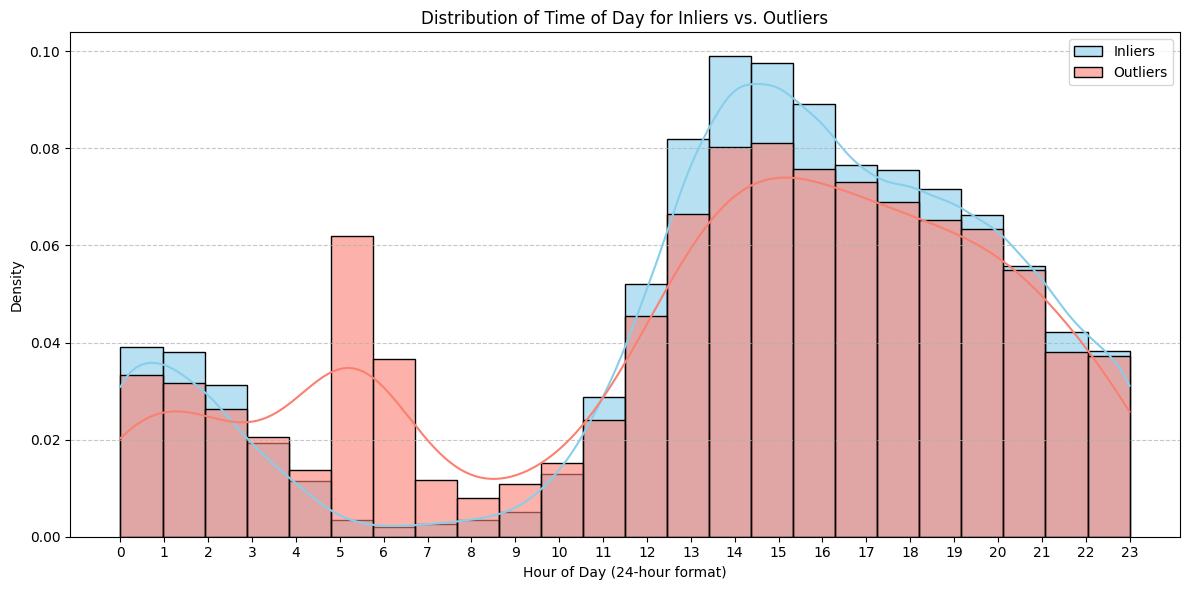

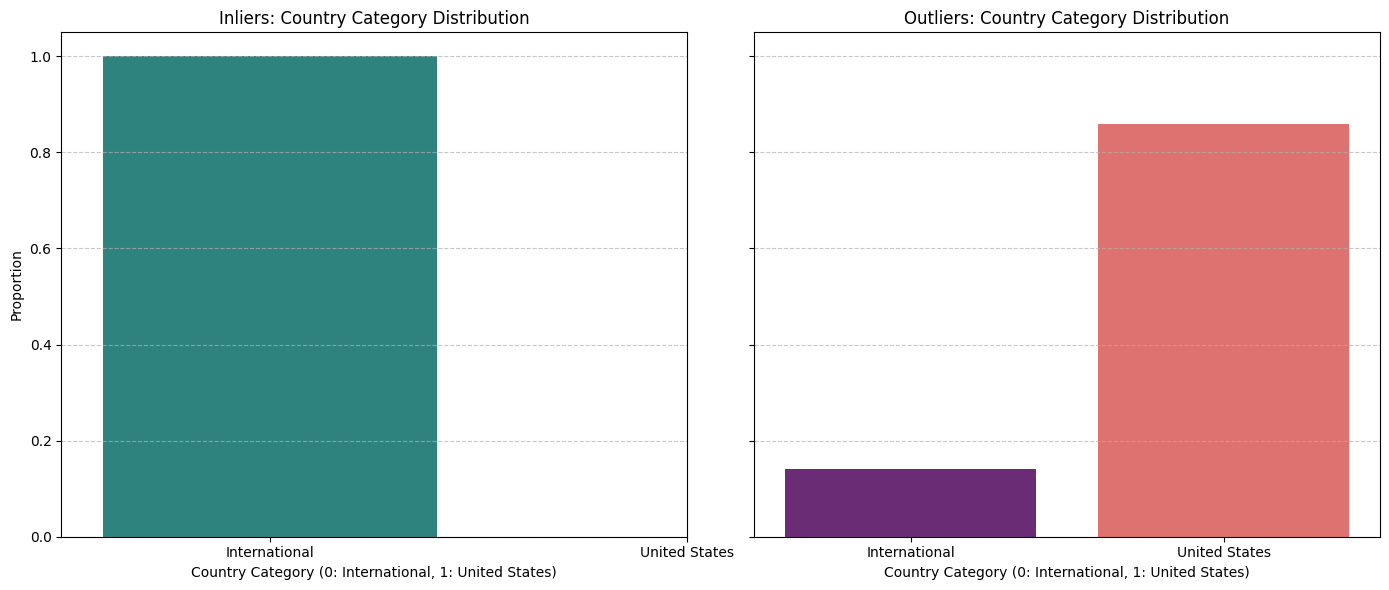

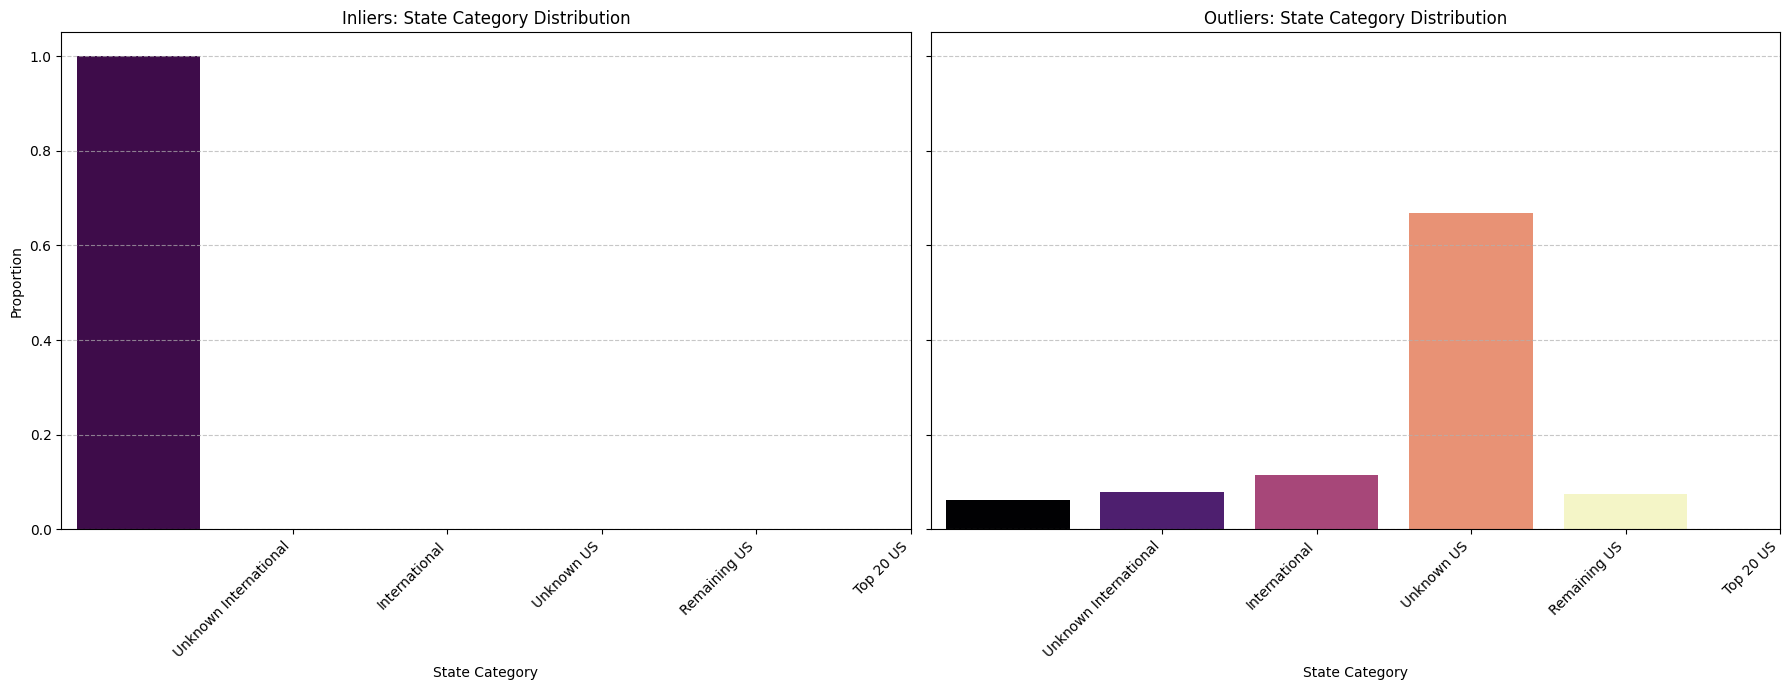

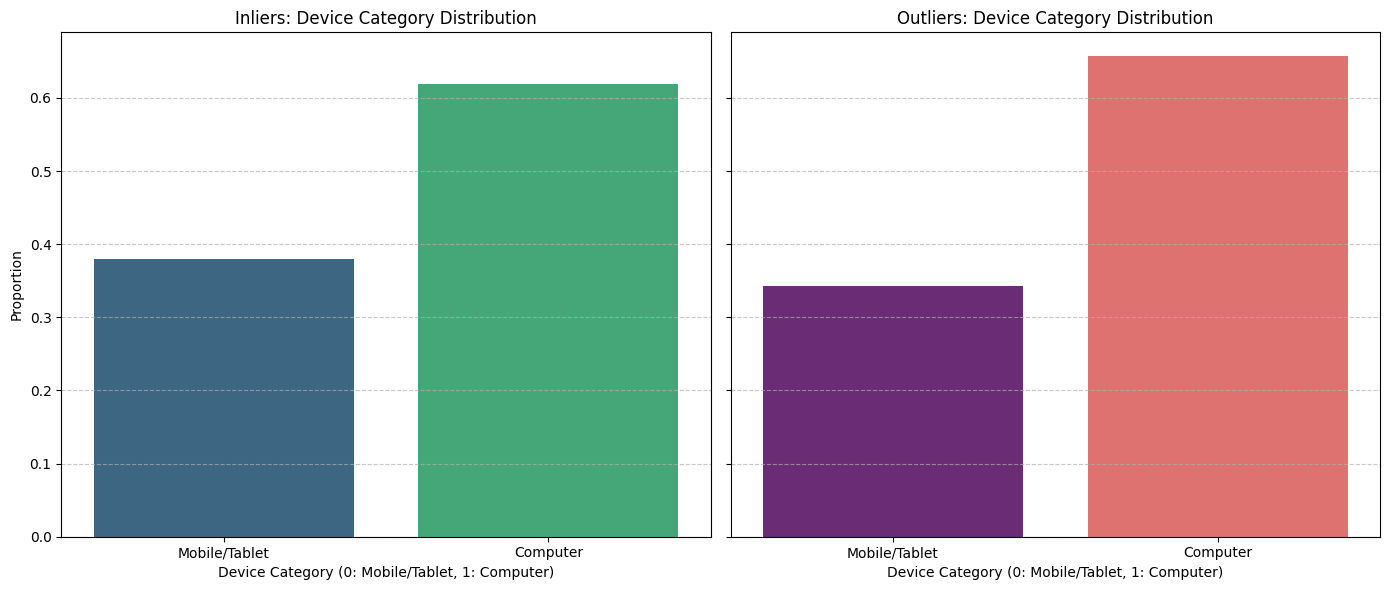

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Visualize Time of Day Distribution for Outliers vs. Inliers ---
plt.figure(figsize=(12, 6))
sns.histplot(inliers_data['time_of_day'], color='skyblue', label='Inliers', kde=True, stat='density', alpha=0.6, bins=24)
sns.histplot(outliers_data['time_of_day'], color='salmon', label='Outliers', kde=True, stat='density', alpha=0.6, bins=24)
plt.title('Distribution of Time of Day for Inliers vs. Outliers')
plt.xlabel('Hour of Day (24-hour format)')
plt.ylabel('Density')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Visualize Country Category Distribution for Outliers vs. Inliers ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.barplot(x=inliers_data['country_category'].value_counts(normalize=True).index,
            y=inliers_data['country_category'].value_counts(normalize=True).values,
            ax=axes[0], palette='viridis', hue=inliers_data['country_category'].value_counts(normalize=True).index, legend=False)
axes[0].set_title('Inliers: Country Category Distribution')
axes[0].set_xlabel('Country Category (0: International, 1: United States)')
axes[0].set_ylabel('Proportion')
axes[0].set_xticks(ticks=[0, 1], labels=['International', 'United States'])
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

sns.barplot(x=outliers_data['country_category'].value_counts(normalize=True).index,
            y=outliers_data['country_category'].value_counts(normalize=True).values,
            ax=axes[1], palette='magma', hue=outliers_data['country_category'].value_counts(normalize=True).index, legend=False)
axes[1].set_title('Outliers: Country Category Distribution')
axes[1].set_xlabel('Country Category (0: International, 1: United States)')
axes[1].set_ylabel('Proportion')
axes[1].set_xticks(ticks=[0, 1], labels=['International', 'United States'])
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# --- Visualize State Category Distribution for Outliers vs. Inliers ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

sns.barplot(x=inliers_data['state_category'].value_counts(normalize=True).index,
            y=inliers_data['state_category'].value_counts(normalize=True).values,
            ax=axes[0], palette='viridis', hue=inliers_data['state_category'].value_counts(normalize=True).index, legend=False)
axes[0].set_title('Inliers: State Category Distribution')
axes[0].set_xlabel('State Category')
axes[0].set_ylabel('Proportion')
axes[0].set_xticks(ticks=[1, 2, 3, 4, 5], labels=['Unknown International', 'International', 'Unknown US', 'Remaining US', 'Top 20 US'], rotation=45, ha='right')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

sns.barplot(x=outliers_data['state_category'].value_counts(normalize=True).index,
            y=outliers_data['state_category'].value_counts(normalize=True).values,
            ax=axes[1], palette='magma', hue=outliers_data['state_category'].value_counts(normalize=True).index, legend=False)
axes[1].set_title('Outliers: State Category Distribution')
axes[1].set_xlabel('State Category')
axes[1].set_ylabel('Proportion')
axes[1].set_xticks(ticks=[1, 2, 3, 4, 5], labels=['Unknown International', 'International', 'Unknown US', 'Remaining US', 'Top 20 US'], rotation=45, ha='right')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# --- Visualize Device Category Distribution for Outliers vs. Inliers ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.barplot(x=inliers_data['device_category'].value_counts(normalize=True).index,
            y=inliers_data['device_category'].value_counts(normalize=True).values,
            ax=axes[0], palette='viridis', hue=inliers_data['device_category'].value_counts(normalize=True).index, legend=False)
axes[0].set_title('Inliers: Device Category Distribution')
axes[0].set_xlabel('Device Category (0: Mobile/Tablet, 1: Computer)')
axes[0].set_ylabel('Proportion')
axes[0].set_xticks(ticks=[0, 1], labels=['Mobile/Tablet', 'Computer'])
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

sns.barplot(x=outliers_data['device_category'].value_counts(normalize=True).index,
            y=outliers_data['device_category'].value_counts(normalize=True).values,
            ax=axes[1], palette='magma', hue=outliers_data['device_category'].value_counts(normalize=True).index, legend=False)
axes[1].set_title('Outliers: Device Category Distribution')
axes[1].set_xlabel('Device Category (0: Mobile/Tablet, 1: Computer)')
axes[1].set_ylabel('Proportion')
axes[1].set_xticks(ticks=[0, 1], labels=['Mobile/Tablet', 'Computer'])
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Comparison of Outliers vs. Inliers Based for Isolation Forest exercise**

Based on the generated plots, here's a summary of the key differences between inliers and outliers:

*   **Time of Day**: The `histplot` shows a noticeable shift in the distribution of login `time_of_day`. While inliers tend to have a peak around the afternoon (mean around 2:26 PM), outliers are slightly more dispersed and have a slightly earlier mean time (around 1:36 PM), suggesting deviations from the most common login hours for anomalous events.

*   **Country Category**: This is a strong differentiator. The bar plots clearly show that nearly **100% of inliers originate from the United States**. In contrast, a significant portion (around 14%) of **outliers come from International locations**, making international logins a key indicator of anomalous behavior.

*   **State Category**: The `state_category` plots further reinforce geographical differences. Almost **all inliers are concentrated in the 'Top 20 US States'**. Outliers, however, are predominantly from 'Remaining US States' and also show notable proportions from 'International State', 'Unknown US State', and 'Unknown International State'. This indicates that logins from less common US states or any international location are more likely to be anomalous.

*   **Device Category**: The distributions of `device_category` (Mobile/Tablet vs. Computer) for both inliers and outliers appear quite similar. This suggests that the device type itself is **not a primary distinguishing factor** for anomalous versus normal login behavior in this dataset.

# Implementing Random Forest Model using `anomaly_prediction` feature/label

We will use the `anomaly_prediction` feature from earlier step to train a Random Forest model.
In this solution approach output of one model (unsupervised anomaly detector) is used as an input feature for Random Forest model (supervised classifier).


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Define features (X) and target (y)
X = df_login_events_final[['time_of_day', 'country_category', 'state_category', 'device_category']]
y = X_with_anomalies['anomaly_prediction'] # Target is the output of Isolation Forest

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames for consistency (optional, but good for inspection)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"X_train scaled shape: {X_train_scaled.shape}")
print(f"X_test scaled shape: {X_test_scaled.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train scaled shape: (75138, 4)
X_test scaled shape: (32202, 4)
y_train shape: (75138,)
y_test shape: (32202,)


In [44]:
# Initialize and train the Random Forest Classifier
# Using default parameters first
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

print("Random Forest model trained successfully!")

Random Forest model trained successfully!


Visualize feature imporatnce based on Random Forest model.

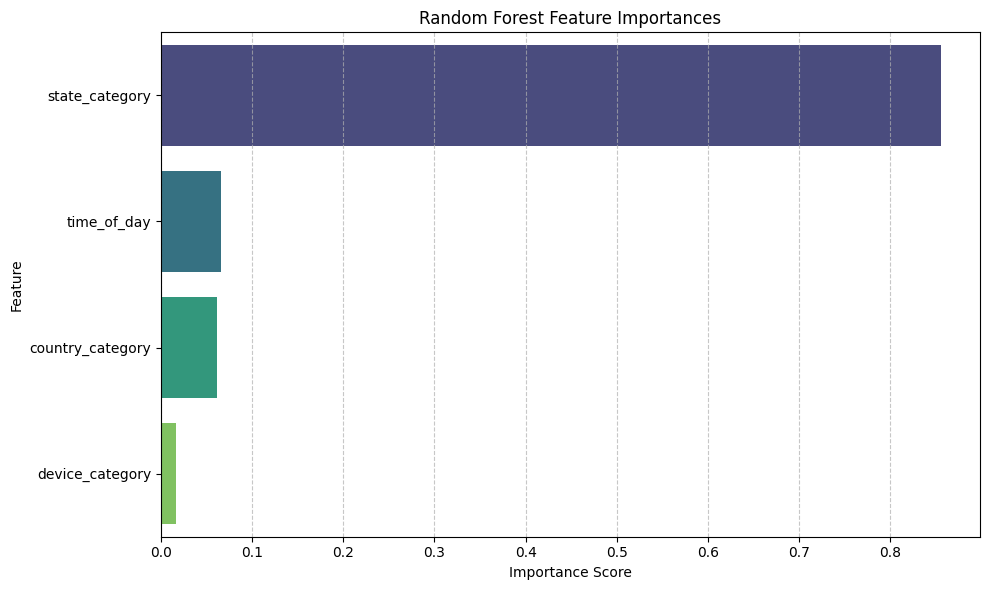

Feature Importances (sorted):


,Feature,Importance
2,state_category,0.855791
0,time_of_day,0.065736
1,country_category,0.061779
3,device_category,0.016694


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importances from the trained Random Forest model
feature_importances = rf_model.feature_importances_

# Get feature names (assuming X was the DataFrame used for training)
feature_names = X.columns

# Create a DataFrame for better visualization and sorting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', hue='Feature', legend=False)
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Feature Importances (sorted):")
display(importance_df)

# Overall Summary of Key Findings

This project involved a comprehensive Exploratory Data Analysis (EDA) and initial unsupervised modeling to identify patterns and potential anomalies in login event data. The key findings are as follows:

### 1. Data Cleaning and Feature Engineering
*   **Data Preparation**: Initial raw login event data was cleaned by handling missing values, standardizing entries (e.g., `request_ip_state`), and removing irrelevant columns. Specifically, 2 records with missing `client_country` were dropped, and `request_ip_state` missing values were imputed.
*   **Feature Creation**: Key new features were engineered from existing data to enhance analytical depth:
    *   `time_of_day`: Hour of login for temporal pattern analysis.
    *   `country_category`: Binary classification of login origin as 'United States' (1) or 'International' (0).
    *   `state_category`: Granular geographical context into 'Top 20 US State' (5), 'Remaining US State' (4), 'Unknown US State' (3), 'International State' (2), and 'Unknown International State' (1).
    *   `device_category`: Binary representation of device type ('Mobile/Tablet' as 0, 'Computer' as 1).

### 2. K-Means Clustering for Behavioral Segmentation
*   **Cluster Discovery**: K-Means clustering (2 clusters) effectively segmented login events into two distinct behavioral patterns:
    *   **Cluster 0 (Larger, ~62% of events)**: Characterized exclusively by 'Computer' logins, with a mean `time_of_day` around 14.86 (2:52 PM), predominantly from the United States and Top 20 US States. This represents the high-volume, regular 'Computer' login behavior.
    *   **Cluster 1 (Smaller, ~38% of events)**: Characterized exclusively by 'Mobile/Tablet' logins, with a mean `time_of_day` around 13.64 (1:38 PM), also predominantly from the United States and Top 20 US States. This cluster highlights regular 'Mobile/Tablet' login activities.
*   **Key Differentiator**: The most significant factor distinguishing these two K-Means clusters was the `device_category`.

### 3. Isolation Forest for Anomaly Detection
*   **Model Application**: Isolation Forest was applied to the `time_of_day`, `country_category`, `state_category`, and `device_category` features to detect anomalous login events, using a `contamination` rate of 0.05. The model identified 4,888 outliers.
*   **Outlier Characteristics (Comparison to Inliers)**: Analysis comparing outliers to inliers revealed significant differentiators:
    *   **Geographical Context**: Outliers showed a significantly higher proportion from 'International' locations (around 14.14%) and 'Remaining US States' (around 66.86%), while inliers were almost exclusively from 'United States' and 'Top 20 US State'.
    *   **Time of Day**: Outliers had a slightly earlier mean login time (~1:36 PM) compared to inliers (~2:26 PM), suggesting deviations from the most frequent login hours.
    *   **Device Type**: The device distribution (Computer vs. Mobile/Tablet) was relatively similar between outliers and inliers, indicating it is not a primary distinguishing factor for anomalous behavior.

### 4. Random Forest Model for Anomaly Prediction
*   A Random Forest classifier was trained using the features (`time_of_day`, `country_category`, `state_category`, `device_category`) to predict the `anomaly_prediction` labels generated by the Isolation Forest model.
*   The Random Forest model achieved **perfect accuracy (1.00)**, with 100% precision, recall, and F1-score for both inlier and outlier classes. This demonstrates that the Random Forest successfully learned the underlying patterns identified by the Isolation Forest.
*   **Feature Importance**: The `state_category` was found to be by far the most important feature, followed by `time_of_day` and `country_category`, while `device_category` had the least importance.

### 5. Conclusion
The EDA successfully transformed raw login event data into a structured format suitable for anomaly detection. Isolation Forest identified that anomalous login events are predominantly characterized by their **international geographical origin or less common US states** and occurrence at **times deviating from peak login activity**, rather than specific device types. These geographical and temporal patterns are robust indicators of potential anomalies for authentication risk assessment, and the Random Forest model effectively captured these relationships.

### Next Step
In final part of capstone project (seperate notebook file), we will revisit Isolation Forest model. We can delete the country_category feature as per our analysis country information has been embedded into state_category feature.
In addition to updating Isolation Forest model, we will tune Random Forest parameters and implement One Class SVM.